# Do MO fit

The MO fit tunes the densification model for a given forcing and set of depths from observations.

First, the FDM should be run for all points at core locations (e.g., generated by `merge_datasets`) with `do_MO_fit` set to True (equivalent to the MO fit in `firn_physics.f90` set to 1)

Then we compare the depths to 550 and 830 between the model and observations, where depths from the model are an average of the year the core was drilled. 

We then need to load the average accumulation from the RACMO input data (the avg `precip` file).

And finally, we can do the MO fit. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import glob
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve, brentq
from process_sumup_cores import def_models
from mo_fit_functions import *

## First we load the core list and match each core with an FDM point

In [3]:
#import cores
cores_df = pd.read_csv("../data/merged/MERGED_CORE_LIST_greenland_2025.csv")

# import fdm reference list
path_to_fdm_locations = "../../reference/FGRN055/"
pointlist_df = pd.read_csv(path_to_fdm_locations+'IN_ll_FGRN055.txt',names=["longitude","latitude","rlat","rlon"],usecols=[0,1,5,6])

In [4]:
# match core locations with FDM points

xs = match_fdm_points_to_cores(core_locations=cores_df[['latitude','longitude']].values,
                              fdm_pointlist_df=pointlist_df)

cores_df["FDM_point_index"] = pointlist_df.loc[xs].index.values
cores_df["FDM_latitude"] = pointlist_df.loc[xs].latitude.values
cores_df["FDM_longitude"] = pointlist_df.loc[xs].longitude.values
cores_df["FDM_rlat"] = pointlist_df.loc[xs].rlat.values
cores_df["FDM_rlon"] = pointlist_df.loc[xs].rlon.values
cores_df = cores_df[cores_df['year'] > 1939] # drop all values earlier than the model run starts
cores_df = cores_df[cores_df['year'] < 2024] # drop all values earlier than the model run starts
cores_df = cores_df.reset_index(drop=True)

cores_df["FDM_depth_to_550"] = np.nan
cores_df["FDM_depth_to_830"] = np.nan
cores_df["Fit_R2"] = np.nan
cores_df["Fit_model"] = ""
cores_df["Fit_failed"] = np.nan

pointlist_cores = np.unique(cores_df["FDM_point_index"].values)

## Now we load 2d data from FDM model output for each point, extract the data for the year the core was drilled, average it over a year, and interpolate to get the depths to 550 and 830.

In [37]:
do_match = True
do_plot = False
target_densities = [550,830]

if do_match:

    models = def_models()

    project_name = "FGRN055-era055_interim_MO_fit_1939-2023"
    project_dir = f"/home/nld4814/scratch/{project_name}/"
    file_list = [f"/home/nld4814/scratch/{project_name}/output/FGRN055_era055_2D_{str(point)}.nc" for point in pointlist_cores]
    merged_df_era055 = find_FDM_depths(cores_df, file_list, project_dir, target_densities, clean_2D=True, do_plot=do_plot, avg_yearly=True)
    
    project_name = "MO_fit_cores_dpy365"
    project_dir = f"/home/nld4814/scratch/{project_name}/"
    file_list = [f for f in glob.glob(project_dir + "output/*" + "2D_" + "*.nc")]
    merged_df_MO = find_FDM_depths(cores_df, file_list, project_dir, target_densities, clean_2D=True, do_plot=do_plot, avg_yearly=True)

    merged_df_MO = merged_df_MO.rename(columns={"FDM_depth_to_550":"FDM_depth_to_550_MO",
                                            "FDM_depth_to_830":"FDM_depth_to_830_MO",
                                            "Fit_R2":"Fit_R2_MO",
                                            "Fit_model":"Fit_model_MO"}
                                            )
    
    merged_df_era055 = merged_df_era055.rename(columns={"FDM_depth_to_550":"FDM_depth_to_550_era055",
                                                        "FDM_depth_to_830":"FDM_depth_to_830_era055",
                                                        "Fit_R2":"Fit_R2_era055",
                                                        "Fit_model":"Fit_model_era055"}
                                                        )

    merged_df = pd.merge(merged_df_era055, merged_df_MO[['FDM_depth_to_550_MO','FDM_depth_to_830_MO','Fit_R2_MO','Fit_model_MO']], left_index=True, right_index=True, how='inner')

    # extract depths from interim runs
    merged_df["FDM_depth_to_550_interim"] = np.nan
    merged_df["FDM_depth_to_830_interim"] = np.nan

    for target_density in target_densities:

        interim_depth = xr.load_dataset(f"/home/nld4814/scratch/FDM-archive-output/FDM_z{target_density}_FGRN055_1957-2020_GrIS_GIC.nc")
        interim_depth = prep_interim_dataset(interim_depth, f"z{target_density}")

        for i, row_i in enumerate(pointlist_cores):
            
            core_matches = merged_df[merged_df["FDM_point_index"] == row_i]
            
            for core_i in range(len(core_matches)):
                core_match = core_matches.iloc[core_i]

                # get year
                core_date= datetime(core_match.year,12,31) #end of year

                # swap ind_t for real(ish) timesteps
                temp = interim_depth.where(interim_depth["FDM_ID"]==core_match.FDM_point_index, drop=True).copy()

                #take mean of depths over the year
                depth = temp.sel(time=slice(datetime(core_match.year,1,1),datetime(core_match.year,12,31))).mean(dim="time")[f"z{target_density}"].values
                del temp
                
                #add depth to merged dataframe
                merged_df.loc[core_match.name, f"FDM_depth_to_{target_density}_interim"] = depth
                
        
        del interim_depth

    merged_df = add_vars_to_merged_df(merged_df) 
    merged_df.to_csv("../data/merged/ALL_fdm_and_core_depths.csv",index=False)

else:
    
    merged_df = pd.read_csv("../data/merged/ALL_fdm_and_core_depths.csv")


Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.
No core match for FDM point 45316 in file 0 - /home/nld4814/scratch/MO_fit_cores_dpy365/output/FGRN055_era055_2D_45316.nc
No core match for FDM point 19123 in file 1 - /home/nld4814/scratch/MO_fit_cores_dpy365/output

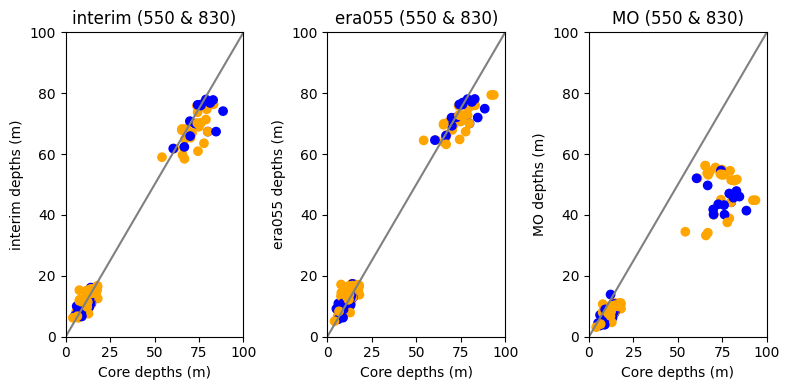

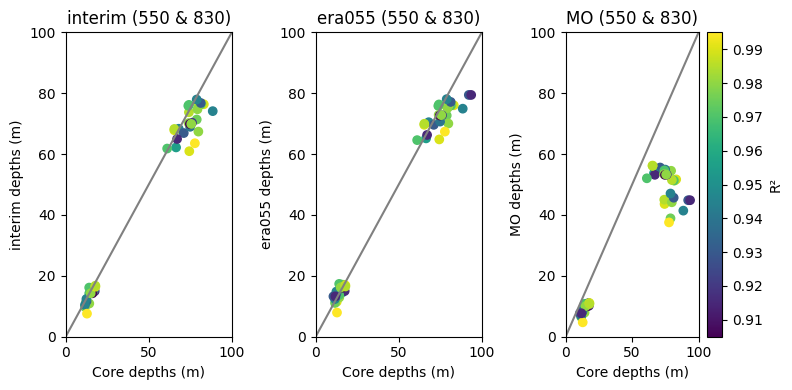

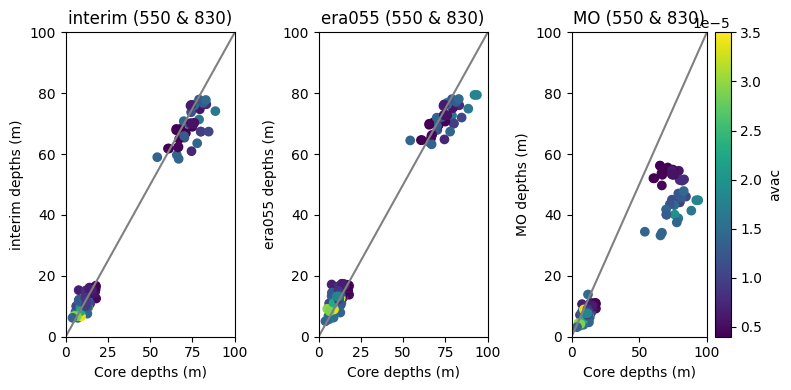

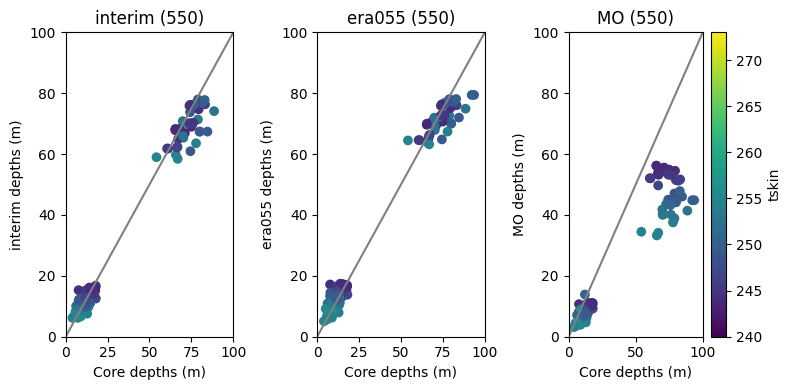

In [38]:
#merged_df.loc[merged_df['source'] == 'PKM standardized cores', 'r2'] = 1

only_PKM = merged_df[merged_df["source"]=='PKM standardized cores']

only_sumup = merged_df[merged_df["source"]=='SUMUP 2024']

merged_df_r2 = merged_df[merged_df['r2_550']>0.8].copy()
merged_df_r2['r2'] = (merged_df_r2['r2_550'] + merged_df_r2['r2_830'])/2

x_1 = np.linspace(0,100,100)
y_1 = np.linspace(0,100,100)

figsize = (8,4)
fig,axs=plt.subplots(1,3,figsize=figsize)

for i, model_ver in enumerate(["interim", "era055", "MO"]):

    axs[i].scatter(merged_df["depth_to_550"],merged_df[f"FDM_depth_to_550_{model_ver}"],c=merged_df["source"].map({'PKM standardized cores':'blue','SUMUP 2024':'orange'}))
    axs[i].plot(x_1,y_1,color='grey')
    axs[i].set_title(f"{model_ver} (550 & 830)")
    axs[i].set_ylabel(f'{model_ver} depths (m)')
    axs[i].set_xlabel('Core depths (m)')

    axs[i].scatter(merged_df["depth_to_830"], merged_df[f"FDM_depth_to_830_{model_ver}"],c=merged_df["source"].map({'PKM standardized cores':'blue','SUMUP 2024':'orange'}))
    axs[i].set_xlim([0,100])
    axs[i].set_ylim([0,100])

plt.tight_layout()

fig,axs=plt.subplots(1,3,figsize=figsize)
for i, model_ver in enumerate(["interim", "era055", "MO"]):

    axs[i].scatter(merged_df_r2["depth_to_550"],merged_df_r2[f"FDM_depth_to_550_{model_ver}"],c=merged_df_r2["r2"])
    axs[i].scatter(merged_df_r2["depth_to_830"], merged_df_r2[f"FDM_depth_to_830_{model_ver}"],c=merged_df_r2["r2"])
    axs[i].plot(x_1,y_1,color='grey')
    
    axs[i].set_title(f"{model_ver} (550 & 830)")
    axs[i].set_ylabel(f'{model_ver} depths (m)')
    axs[i].set_xlabel('Core depths (m)')
    axs[i].set_xlim([0,100])
    axs[i].set_ylim([0,100])

plt.colorbar(axs[2].collections[0], ax=axs[2], label='R²')
plt.tight_layout()

fig,axs=plt.subplots(1,3,figsize=figsize)
for i, model_ver in enumerate(["interim", "era055", "MO"]):

    axs[i].scatter(merged_df["depth_to_550"],merged_df[f"FDM_depth_to_550_{model_ver}"],c=merged_df["precip"],vmin=0.4*10**-5,vmax=3.5*10**-5)
    axs[i].plot(x_1,y_1,color='grey')
    axs[i].set_title(f"{model_ver} (550 & 830)")

    axs[i].set_ylabel(f'{model_ver} depths (m)')
    axs[i].set_xlabel('Core depths (m)')
    
    axs[i].scatter(merged_df["depth_to_830"], merged_df[f"FDM_depth_to_830_{model_ver}"],c=merged_df["precip"],vmin=0.4*10**-5,vmax=3.5*10**-5)

    axs[i].set_xlim([0,100])
    axs[i].set_ylim([0,100])

plt.colorbar(axs[2].collections[0], ax=axs[2], label='avac')
plt.tight_layout()

fig,axs=plt.subplots(1,3,figsize=figsize)
for i, model_ver in enumerate(["interim", "era055", "MO"]):

    axs[i].scatter(merged_df["depth_to_550"],merged_df[f"FDM_depth_to_550_{model_ver}"],c=merged_df["tskin"],vmin=240,vmax=273)
    axs[i].plot(x_1,y_1,color='grey')
    axs[i].set_title(f"{model_ver} (550)")

    axs[i].set_ylabel(f'{model_ver} depths (m)')
    axs[i].set_xlabel('Core depths (m)')
    

    axs[i].scatter(merged_df["depth_to_830"], merged_df[f"FDM_depth_to_830_{model_ver}"],c=merged_df["tskin"],vmin=240,vmax=273)

    axs[i].set_xlim([0,100])
    axs[i].set_ylim([0,100])

plt.colorbar(axs[2].collections[0], ax=axs[2], label='tskin')
plt.tight_layout()

## MO Fitting with Accumulation

Now we fit MO as a function of accumulation for both density regimes (550 and 830 kg/m³).

The approach:
1. Calculate optimal MO at each core location (MO that would make model match observations)
2. Fit MO as function of accumulation using forms from `firn_physics.f90`:
   - Low density (≤550): `MO = a + b*log(acav)`
   - High density (>550): `MO = a + b*log(acav)` or `MO = a * acav^b + c`


FITTING MO FOR 550 kg/m³ DENSITY REGIME

Logarithmic fit: MO = 0.7522 + -0.0178*log(snowfall)
  R² = 0.0107
  RMSE = 0.0863
Current FGRN fit: MO = 0.6688 + 0.0048*log(acav)

FITTING MO FOR 830 kg/m³ DENSITY REGIME

Logarithmic fit: MO = 2.0131 + -0.2486*log(snowfall)
  R² = 0.9195
  RMSE = 0.0396
Current FGRN fit: MO = 1.7465 - 0.2045*log(acav)

Powerlog fit: MO = 5.7819 * snowfall^-0.4187 + 0.0527
  R² = 0.9323
  RMSE = 0.0363
Current ANT27 powerlog: MO = 6.387 * acav^(-0.477) + 0.195
Average MO at 550 is:  0.6521699487548615


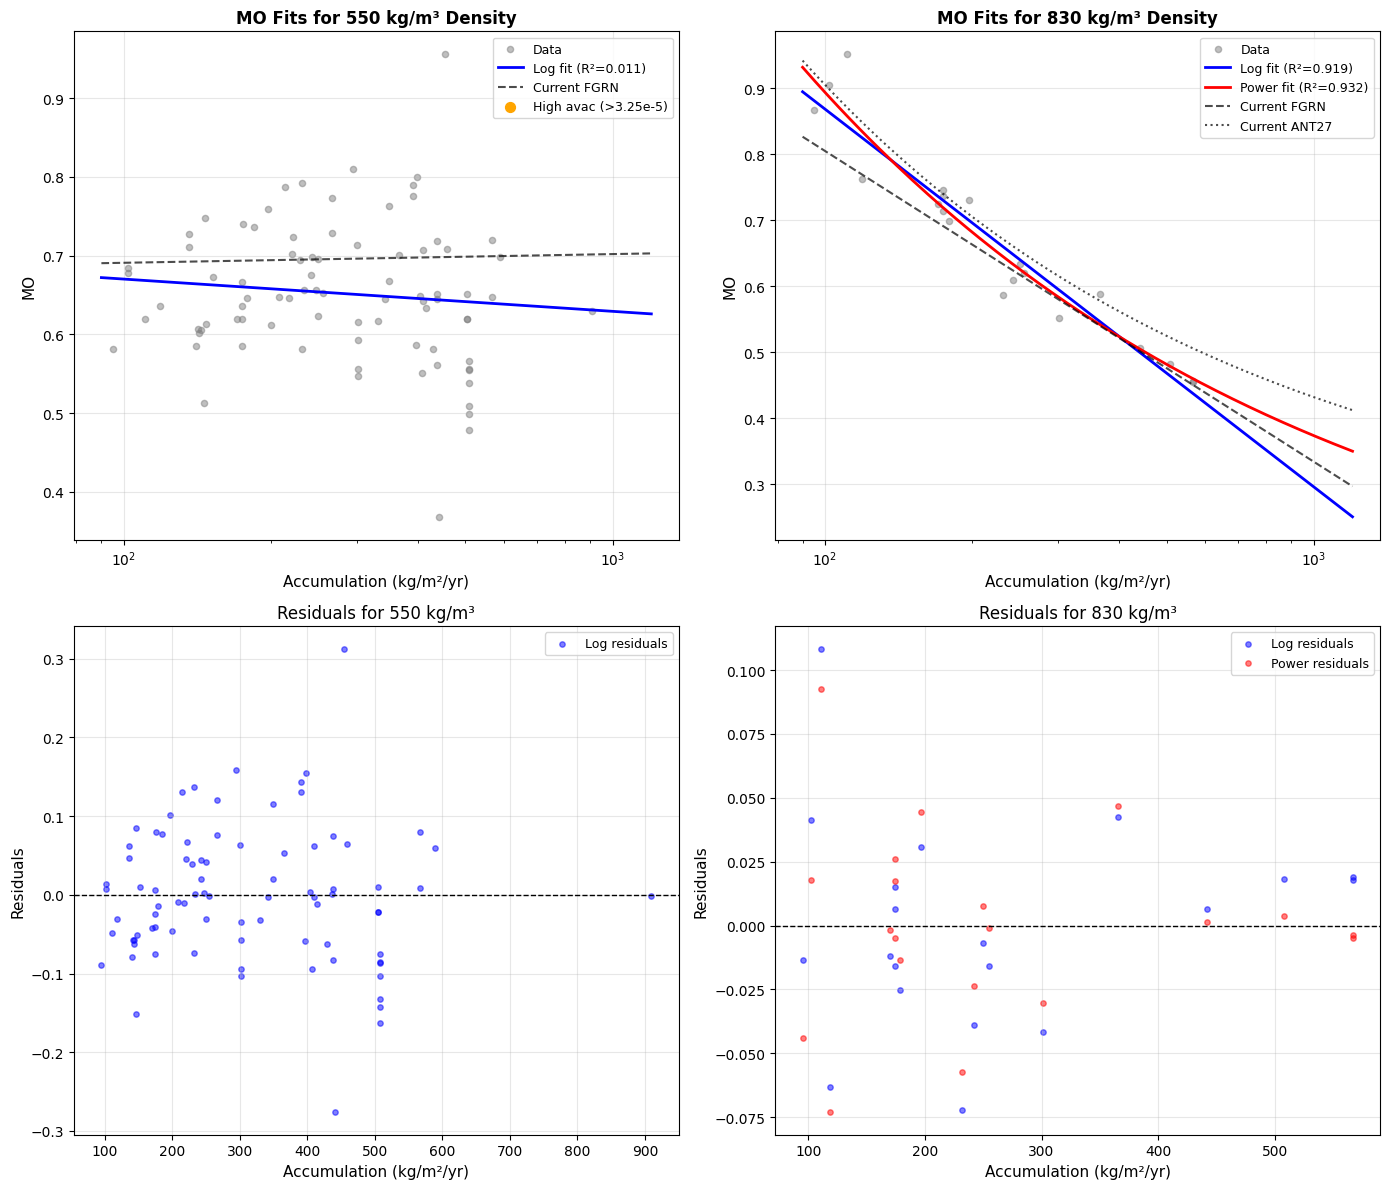

In [7]:
only_PKM = merged_df[merged_df["source"]=='PKM standardized cores']
only_sumup = merged_df[merged_df["source"]=='SUMUP 2024']
merged_df_r2 = merged_df[merged_df['r2_550']>0.8].copy()

df_clean, fit_results = do_MO_fit(merged_df_r2.copy(),var="snowfall")
plot_MO_fits(df_clean, fit_results, var="snowfall")

In [8]:
# extracts FDM points nearest to cores

save_pointlist = True

pointlist = merged_df['FDM_point_index'].values

if save_pointlist:
    output_path = "../../rundir/pointlists/pointlist_from_cores_161225.csv"
    np.savetxt(output_path, pointlist, fmt='%d')

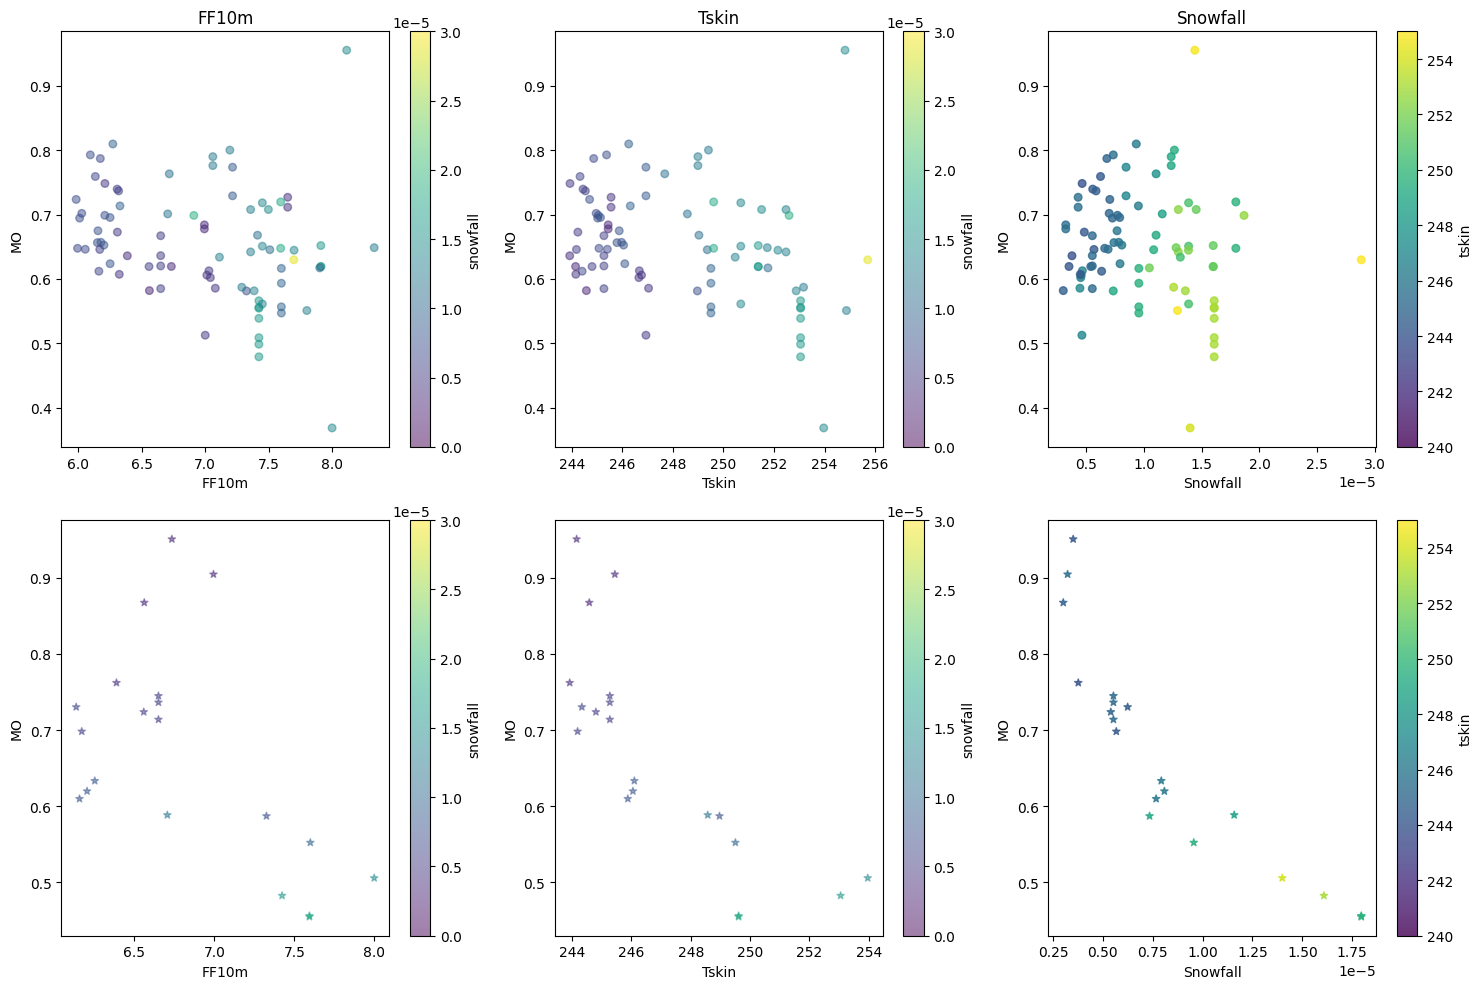

In [9]:
# plot MO vs. other variables

fig, axs = plt.subplots(2,3,figsize=(15,10))

var = "ff10m"
axs[0,0].scatter(df_clean[var], df_clean['MO_optimal_550'], alpha=0.5, s=30, label='550', c=df_clean['snowfall'],vmin=0,vmax=3e-5)
plt.colorbar(axs[0,0].collections[0],label="snowfall")
axs[0,0].set_xlabel("FF10m")
axs[0,0].set_ylabel("MO")

axs[0,0].set_title("FF10m")

axs[1,0].scatter(df_clean[var], df_clean['MO_optimal_830'], alpha=0.5, s=30, marker="*",label='830', c=df_clean['snowfall'],vmin=0,vmax=3e-5)
plt.colorbar(axs[1,0].collections[0],label="snowfall")
axs[1,0].set_xlabel("FF10m")
axs[1,0].set_ylabel("MO")


var = "tskin"
axs[0,1].scatter(df_clean[var], df_clean['MO_optimal_550'], alpha=0.5, s=30, label='550', c=df_clean['snowfall'],vmin=0,vmax=3e-5)
plt.colorbar(axs[0,1].collections[0],label="snowfall")

axs[0,1].set_xlabel("Tskin")
axs[0,1].set_ylabel("MO")

axs[0,1].set_title("Tskin")

axs[1,1].scatter(df_clean[var], df_clean['MO_optimal_830'], alpha=0.5, s=30, marker="*",label='830', c=df_clean['snowfall'],vmin=0,vmax=3e-5)
plt.colorbar(axs[1,1].collections[0],label="snowfall")

axs[1,1].set_xlabel("Tskin")
axs[1,1].set_ylabel("MO")



var = "snowfall"
axs[0,2].scatter(df_clean[var], df_clean['MO_optimal_550'], alpha=0.8, s=30, label='550', c=df_clean['tskin'],vmin=240,vmax=255)
plt.colorbar(axs[0,2].collections[0],label="tskin")

axs[0,2].set_xlabel("Snowfall")
axs[0,2].set_ylabel("MO")

axs[0,2].set_title("Snowfall")

axs[1,2].scatter(df_clean[var], df_clean['MO_optimal_830'], alpha=0.8, s=30, marker="*",label='830', c=df_clean['tskin'],vmin=240,vmax=255)
plt.colorbar(axs[1,2].collections[0],label="tskin")

axs[1,2].set_xlabel("Snowfall")
axs[1,2].set_ylabel("MO")


plt.tight_layout()

## The values from the MO-fit should now be put in the model (firn_physics.f90) for the relevant domain/regime. 

Then run the model with the new MO fit

## Now we can see how the MO fit improved (or not) the depth estimates compared to core depths

In [39]:
do_match = True

#if do_match:

merged_df_all = merged_df.copy()

    #for fit_type in ["new"]:#"power", "log", "ffav"]:

fit_type="new"
try: 

    project_name = f"test_FGRN055-era055_1939-2023"
    project_dir = f"/home/nld4814/scratch/{project_name}/"

    file_list = []
    for point in pointlist:
        strpt = str(point)
        file_name = f"/home/nld4814/scratch/{project_name}/output/FGRN055_era055_2D_{strpt}.nc"
        file_list.append(file_name)

    merged_df_all = find_FDM_depths(merged_df_all, file_list, project_dir, target_densities, clean_2D=True, do_plot=False, avg_yearly=True)

    merged_df_all = merged_df_all.rename(columns={"FDM_depth_to_550":f"FDM_depth_to_550_era055_{fit_type}_fit",
                                        "FDM_depth_to_830":f"FDM_depth_to_830_era055_{fit_type}_fit",
                                        "Fit_R2":f"Fit_R2_era055_{fit_type}_fit",
                                        "Fit_model":f"Fit_model_era055_{fit_type}_fit"}
                                            )
except Exception as e:
    print(f"Fit type {fit_type} not available")

    #merged_df_all.to_csv("../data/merged/NEW_MO_with_fdm_and_core_depths.csv",index=False)

#else:
    #merged_df_era055 = pd.read_csv("../data/temp/fdm_match_depths_era055.csv")
    #merged_df_MO = pd.read_csv("../data/temp/fdm_match_depths_MO.csv")
    #merged_df_all = pd.read_csv("../data/merged/NEW_MO_with_fdm_and_core_depths.csv")


Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Power law: Failed to fit - Optimal parameters not found: Number of calls to function has reached maxfev = 800.


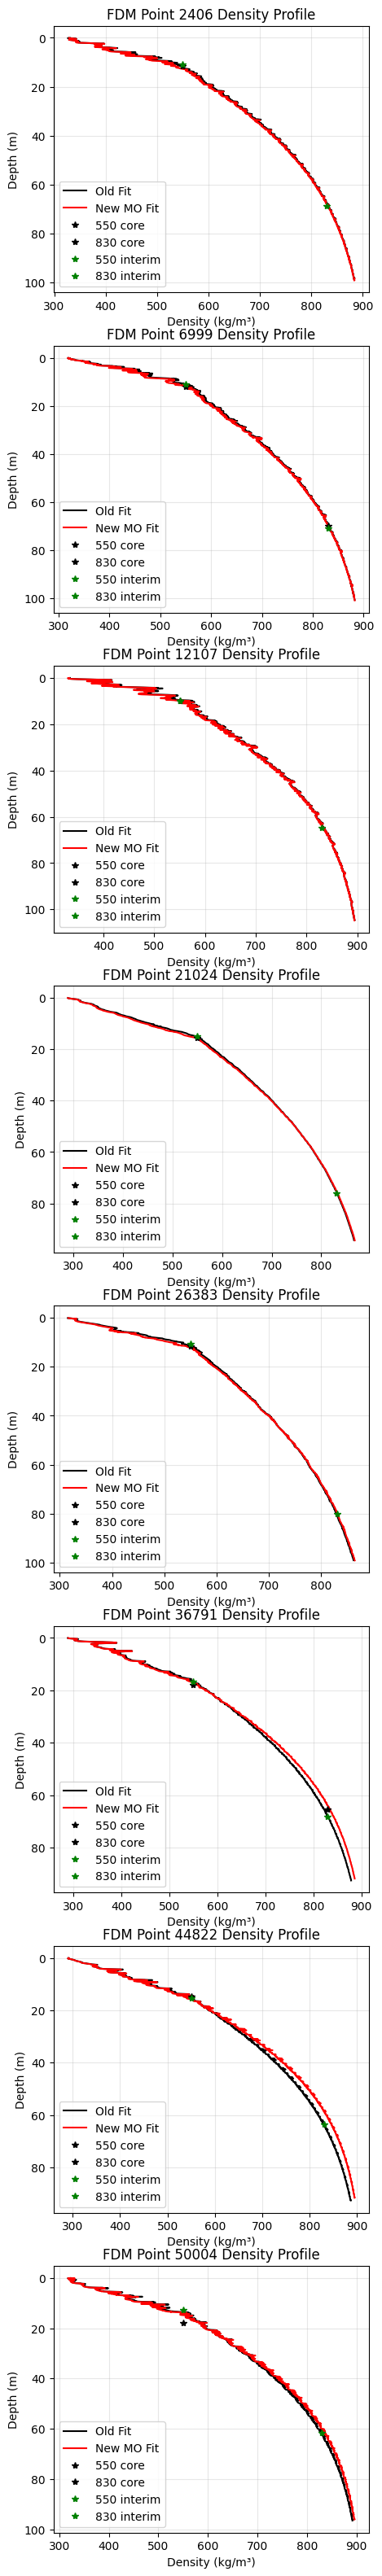

In [40]:
old_runs_dir = "/home/nld4814/scratch/FGRN055-era055_interim_MO_fit_1939-2023/"
#power_runs_dir = "/home/nld4814/scratch/test-new_MO_fit_power-111225/"
#log_runs_dir = "/home/nld4814/scratch/test-new_MO_fit_log-111225/"
new_runs_dir = f"/home/nld4814/scratch/test_FGRN055-era055_1939-2023/"
fdm_points = ["2406", "6999", "12107", "21024", "26383", "36791", "44822", "50004"]

fig, axes = plt.subplots(len(fdm_points), 1, figsize=(5, 5*len(fdm_points)))

for point in fdm_points:

    old_file = old_runs_dir + f"output/FGRN055_era055_2D_{point}.nc"
    #power_runs_file = power_runs_dir + f"output/FGRN055_era055_2D_{point}.nc"
    #log_runs_file = log_runs_dir + f"output/FGRN055_era055_2D_{point}.nc"
    new_runs_file = new_runs_dir + f"output/FGRN055_era055_2D_{point}.nc"

    old_ds = load_2d_file(old_runs_dir, old_file, clean_2D=True)
    #power_ds = load_2d_file(power_runs_dir, power_runs_file, clean_2D=True)
    #log_ds = load_2d_file(log_runs_dir, log_runs_file, clean_2D=True)
    new_ds = load_2d_file(new_runs_dir, new_runs_file, clean_2D=True)
    
    # old_file = old_runs_dir + f"output/FGRN055_era055_2D_{point}.nc"
    # new_file = new_runs_dir + f"output/FGRN055_era055_2D_{point}.nc"

    # old_ds = load_2d_file(old_runs_dir, old_file, clean_2D=True)
    # new_ds = load_2d_file(new_runs_dir, new_file, clean_2D=True)

    try: 
        year = merged_df_all[merged_df_all["FDM_point_index"]==int(point)].iloc[0]["year"]
    except Exception:
        continue
    depth_to_550_core = merged_df_all[merged_df_all["FDM_point_index"]==int(point)].iloc[0]["depth_to_550"]
    depth_to_830_core = merged_df_all[merged_df_all["FDM_point_index"]==int(point)].iloc[0]["depth_to_830"]
    depth_to_550_interim = merged_df_all[merged_df_all["FDM_point_index"]==int(point)].iloc[0]["FDM_depth_to_550_interim"]
    depth_to_830_interim = merged_df_all[merged_df_all["FDM_point_index"]==int(point)].iloc[0]["FDM_depth_to_830_interim"]

    old_ds = match_fdm_to_year(old_ds, year, avg_yearly=True)
    new_ds = match_fdm_to_year(new_ds, year, avg_yearly=True)
    #power_ds = match_fdm_to_year(power_ds, year, avg_yearly=True)
    #log_ds = match_fdm_to_year(log_ds, year, avg_yearly=True)

    depth_old = old_ds['depth'].values
    old_density = old_ds['dens'].values
    depth_new = new_ds['depth'].values
    new_density = new_ds['dens'].values
    #power_depth = power_ds['depth'].values
    #power_density = power_ds['dens'].values
    #log_depth = log_ds['depth'].values
    #log_density = log_ds['dens'].values

    ax1 = axes[fdm_points.index(point)]
    ax1.plot(old_density, depth_old, label='Old Fit', color='black')
    ax1.plot(new_density, depth_new, label='New MO Fit', color='red')
    #ax1.plot(power_density, power_depth, label='Power', color='red')
    #ax1.plot(log_density, log_depth, label='Log', color='blue')
    ax1.plot(550, depth_to_550_core, 'k*', label='550 core')
    ax1.plot(830, depth_to_830_core, 'k*', label='830 core')
    ax1.plot(550, depth_to_550_interim, 'g*', label='550 interim')
    ax1.plot(830, depth_to_830_interim, 'g*', label='830 interim')
    ax1.invert_yaxis()
    ax1.set_xlabel('Density (kg/m³)')
    ax1.set_ylabel('Depth (m)')
    ax1.set_title(f'FDM Point {point} Density Profile')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

IndexError: index 4 is out of bounds for axis 1 with size 3

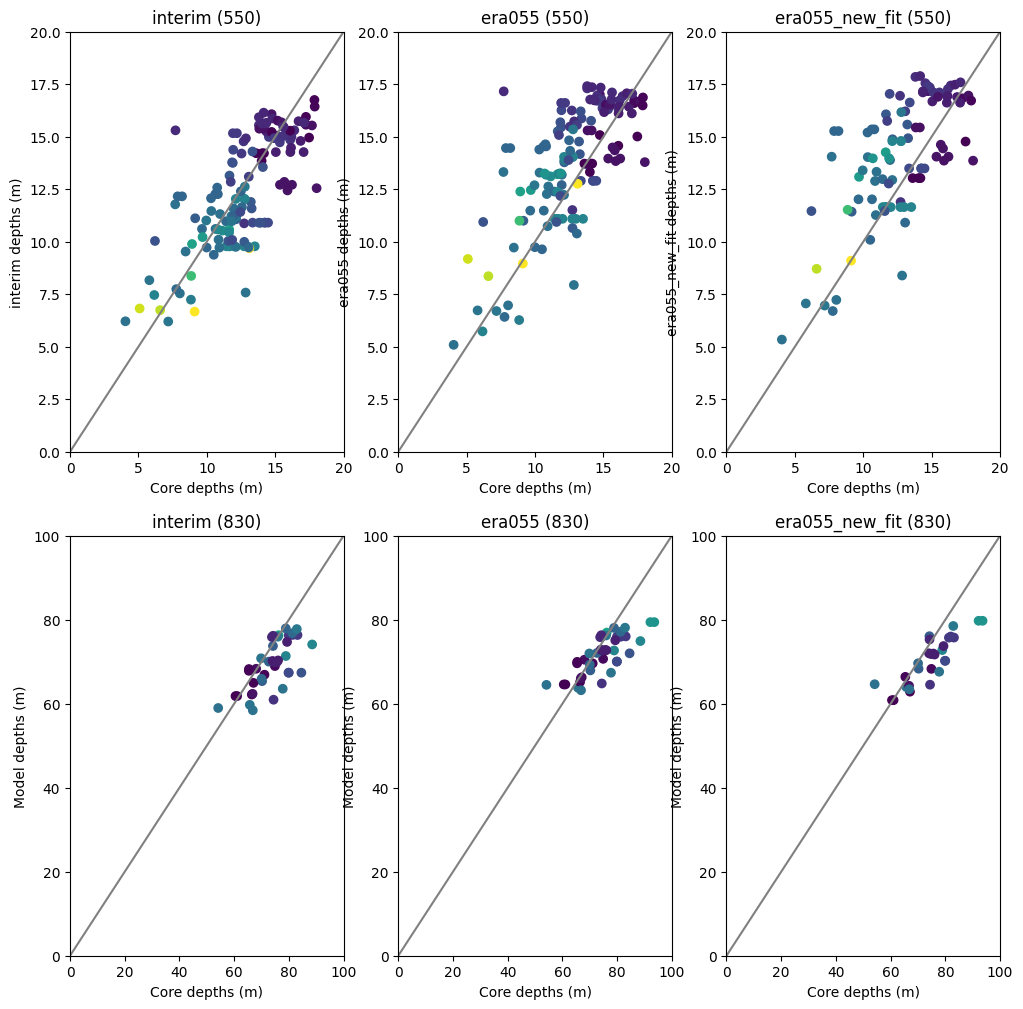

In [41]:
plot_list = ["interim", "era055", "era055_new_fit"] #["interim", "era055", "era055_power_fit", "era055_log_fit", "MO"]
fig,axs=plt.subplots(2,len(plot_list),figsize=(12,12))

spy = 365.25*3600*24

x_1 = np.linspace(0,100,100)
y_1 = np.linspace(0,100,100)

# for i, model_ver in enumerate(plot_list):

#     axs[0,i].scatter(merged_df_all["depth_to_550"],merged_df_all[f"FDM_depth_to_550_{model_ver}"],c=merged_df_all["source"].map({'PKM standardized cores':'blue','SUMUP 2024':'orange'}))
#     axs[0,i].plot(x_1,y_1,color='grey')
#     axs[0,i].set_title(f"{model_ver} (550)")
#     axs[0,i].set_xlim([0,20])
#     axs[0,i].set_ylim([0,20])
#     axs[0,i].set_ylabel(f'{model_ver} depths (m)')
#     axs[0,i].set_xlabel('Core depths (m)')

#     axs[1,i].scatter(merged_df_all["depth_to_830"], merged_df_all[f"FDM_depth_to_830_{model_ver}"],c=merged_df_all["source"].map({'PKM standardized cores':'blue','SUMUP 2024':'orange'}))
#     axs[1,i].plot(x_1,y_1,color='grey')
#     axs[1,i].set_title(f"{model_ver} (830)")
#     axs[1,i].set_xlim([0,100])
#     axs[1,i].set_ylim([0,100])
#     axs[1,i].set_ylabel('Model depths (m)')
#     axs[1,i].set_xlabel('Core depths (m)')

# plt.tight_layout()

#fig,axs=plt.subplots(2,len(plot_list),figsize=(12,12))

# for i, model_ver in enumerate(plot_list):

#     axs[0,i].scatter(merged_df_all["depth_to_550"],merged_df_all[f"FDM_depth_to_550_{model_ver}"],c=merged_df_all["r2_550"])
#     axs[0,i].plot(x_1,y_1,color='grey')
#     axs[0,i].set_title(f"{model_ver} (550)")
#     axs[0,i].set_xlim([0,20])
#     axs[0,i].set_ylim([0,20])
#     axs[0,i].set_ylabel(f'{model_ver} depths (m)')
#     axs[0,i].set_xlabel('Core depths (m)')
    

#     axs[1,i].scatter(merged_df_all["depth_to_830"], merged_df_all[f"FDM_depth_to_830_{model_ver}"],c=merged_df_all["r2_830"])
#     axs[1,i].plot(x_1,y_1,color='grey')
#     axs[1,i].set_title(f"{model_ver} (830)")
#     axs[1,i].set_xlim([0,100])
#     axs[1,i].set_ylim([0,100])
#     axs[1,i].set_ylabel('Model depths (m)')
#     axs[1,i].set_xlabel('Core depths (m)')

# plt.colorbar(axs[0,2].collections[0], ax=axs[0,2], label='R²')
# plt.colorbar(axs[1,2].collections[0], ax=axs[1,2], label='R²')

# plt.tight_layout()

# fig,axs=plt.subplots(2,len(plot_list),figsize=(12,12))

for i, model_ver in enumerate(plot_list):

    axs[0,i].scatter(merged_df_all["depth_to_550"],merged_df_all[f"FDM_depth_to_550_{model_ver}"],c=merged_df_all["snowfall"]*spy,vmin=100,vmax=1000)
    axs[0,i].plot(x_1,y_1,color='grey')
    axs[0,i].set_title(f"{model_ver} (550)")
    axs[0,i].set_xlim([0,20])
    axs[0,i].set_ylim([0,20])
    axs[0,i].set_ylabel(f'{model_ver} depths (m)')
    axs[0,i].set_xlabel('Core depths (m)')
    

    axs[1,i].scatter(merged_df_all["depth_to_830"], merged_df_all[f"FDM_depth_to_830_{model_ver}"],c=merged_df_all["snowfall"]*spy,vmin=100,vmax=1000)
    axs[1,i].plot(x_1,y_1,color='grey')
    axs[1,i].set_title(f"{model_ver} (830)")
    axs[1,i].set_xlim([0,100])
    axs[1,i].set_ylim([0,100])
    axs[1,i].set_ylabel('Model depths (m)')
    axs[1,i].set_xlabel('Core depths (m)')

plt.colorbar(axs[0,4].collections[0], ax=axs[0,4], label='snowfall')
plt.colorbar(axs[1,4].collections[0], ax=axs[1,4], label='snowfall')

plt.tight_layout()

# fig,axs=plt.subplots(2,len(plot_list),figsize=(12,12))

# for i, model_ver in enumerate(plot_list):

#     axs[0,i].scatter(merged_df_all["depth_to_550"],merged_df_all[f"FDM_depth_to_550_{model_ver}"],c=merged_df_all["tskin"],vmin=240,vmax=273)
#     axs[0,i].plot(x_1,y_1,color='grey')
#     axs[0,i].set_title(f"{model_ver} (550)")
#     axs[0,i].set_xlim([0,20])
#     axs[0,i].set_ylim([0,20])
#     axs[0,i].set_ylabel(f'{model_ver} depths (m)')
#     axs[0,i].set_xlabel('Core depths (m)')
    

#     axs[1,i].scatter(merged_df_all["depth_to_830"], merged_df_all[f"FDM_depth_to_830_{model_ver}"],c=merged_df_all["tskin"],vmin=240,vmax=273)
#     axs[1,i].plot(x_1,y_1,color='grey')
#     axs[1,i].set_title(f"{model_ver} (830)")
#     axs[1,i].set_xlim([0,100])
#     axs[1,i].set_ylim([0,100])
#     axs[1,i].set_ylabel('Model depths (m)')
#     axs[1,i].set_xlabel('Core depths (m)')

# plt.colorbar(axs[0,2].collections[0], ax=axs[0,2], label='tskin')
# plt.colorbar(axs[1,2].collections[0], ax=axs[1,2], label='tskin')


# plt.tight_layout()

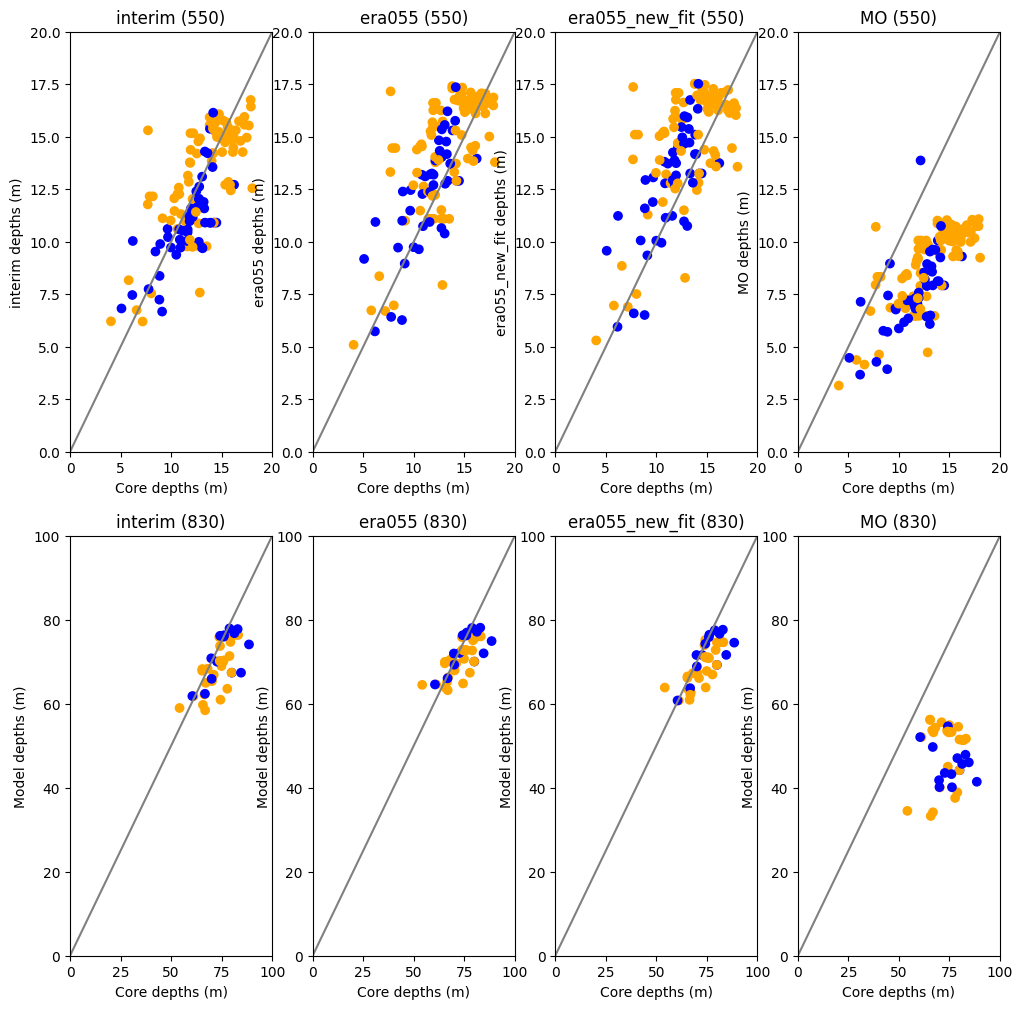

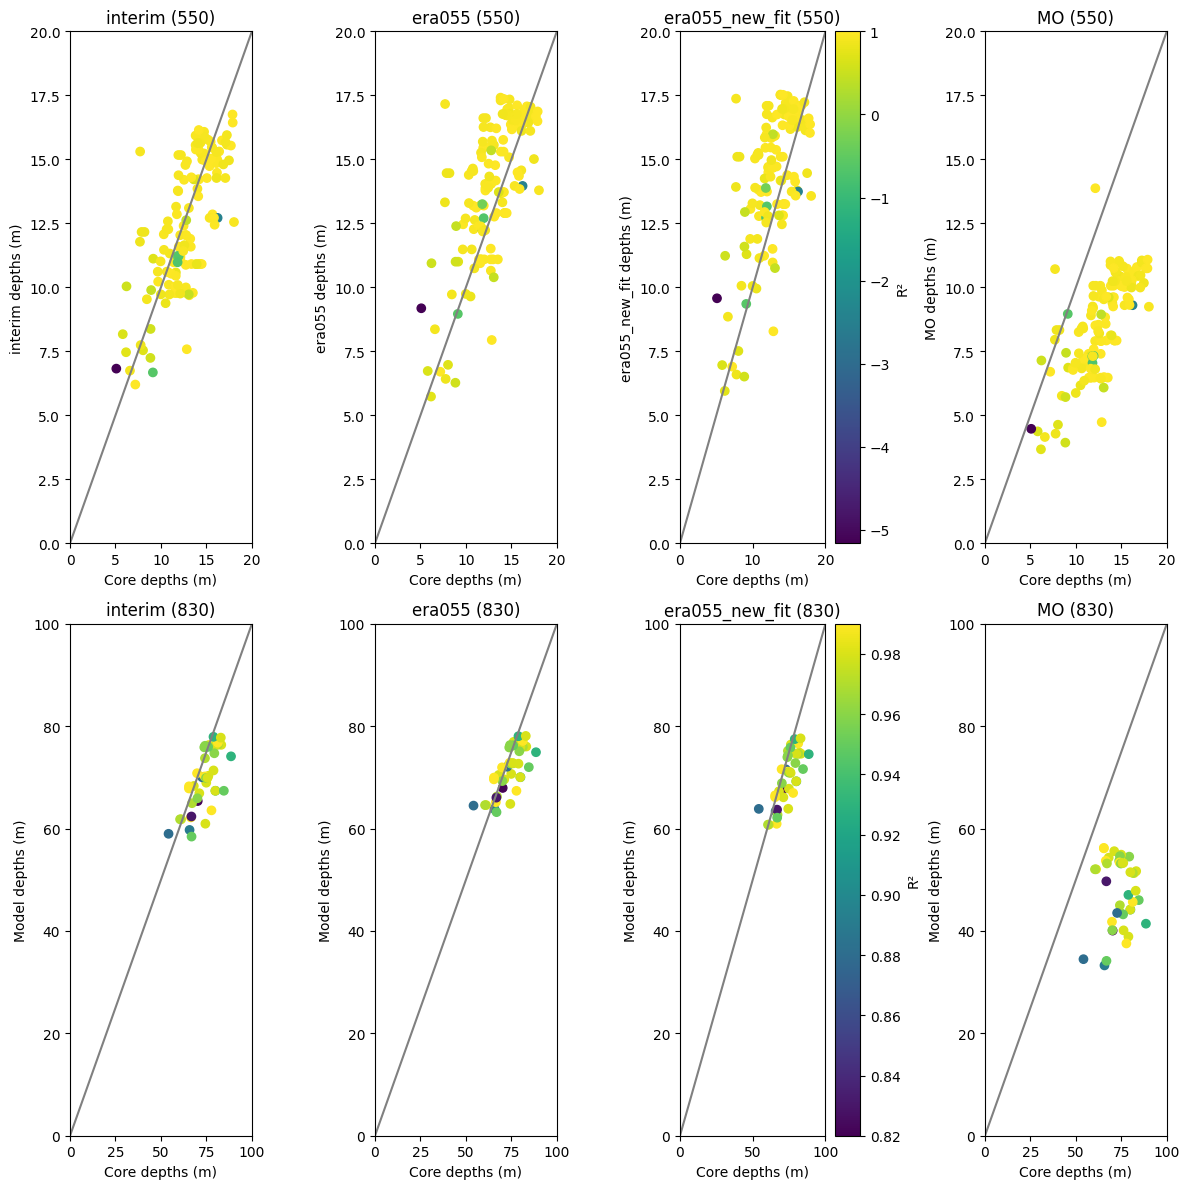

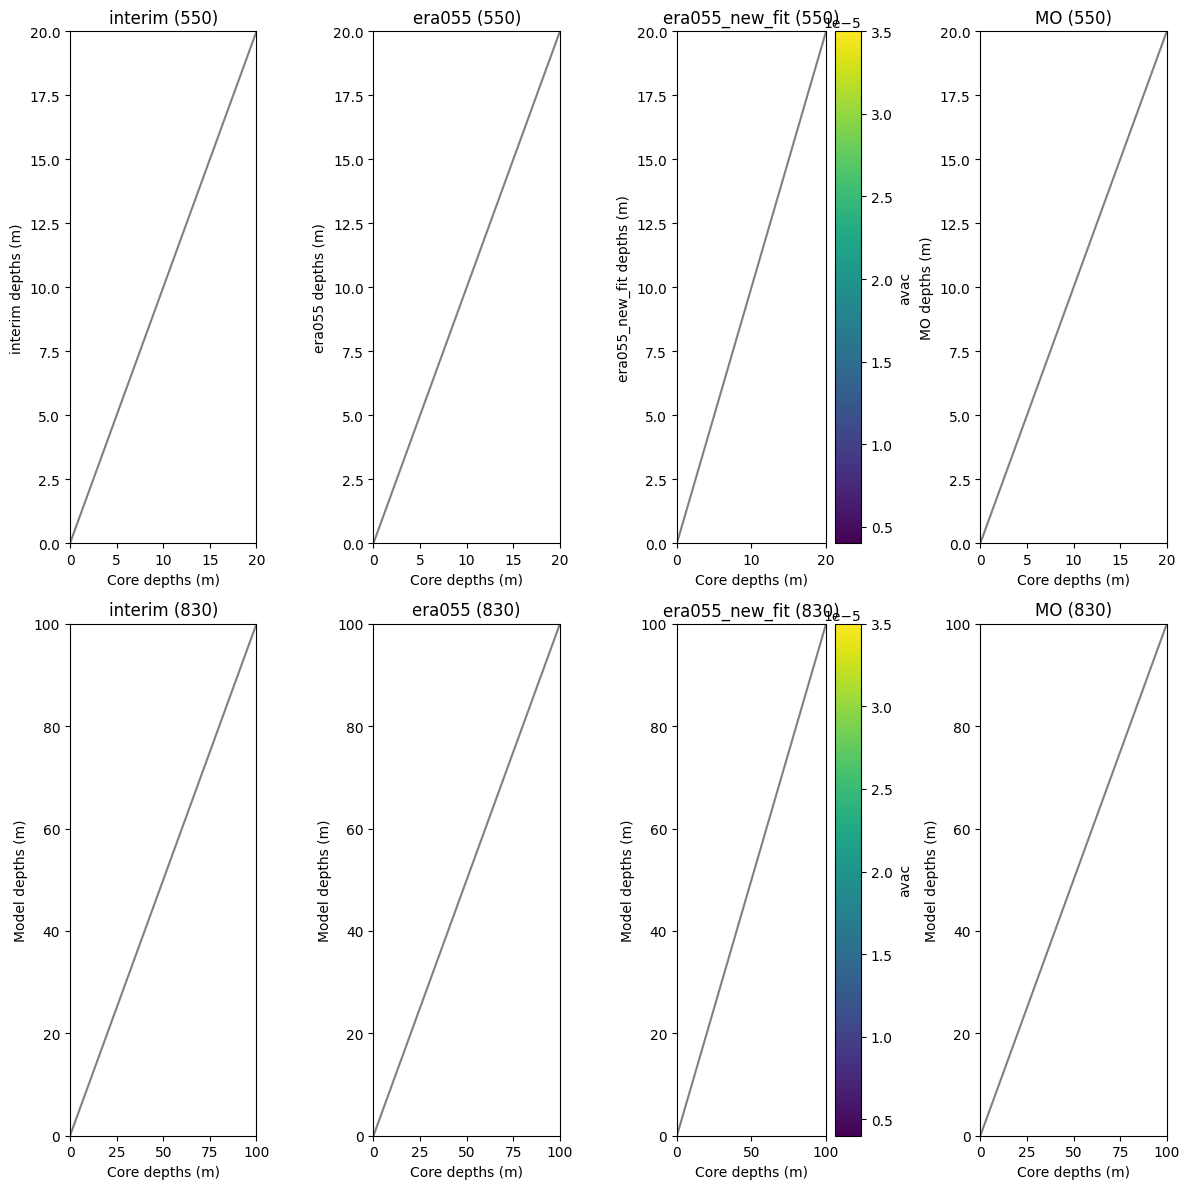

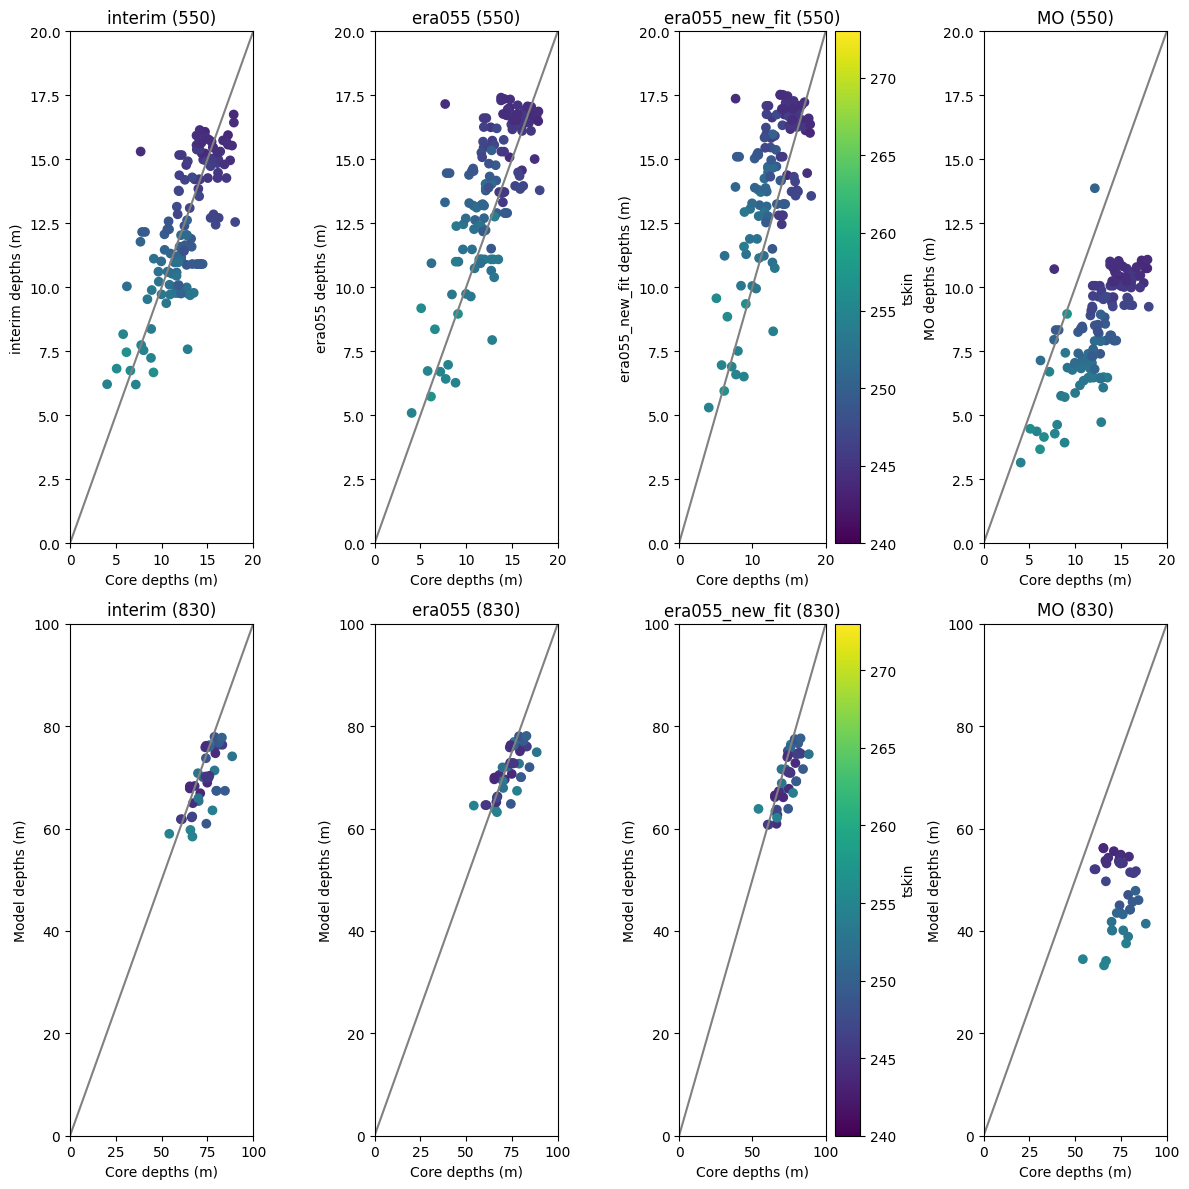

In [20]:
fig,axs=plt.subplots(2,4,figsize=(12,12))

x_1 = np.linspace(0,100,100)
y_1 = np.linspace(0,100,100)

for i, model_ver in enumerate(["interim", "era055", "era055_new_fit", "MO"]):

    axs[0,i].scatter(merged_df_all["depth_to_550"],merged_df_all[f"FDM_depth_to_550_{model_ver}"],c=merged_df_all["source"].map({'PKM standardized cores':'blue','SUMUP 2024':'orange'}))
    axs[0,i].plot(x_1,y_1,color='grey')
    axs[0,i].set_title(f"{model_ver} (550)")
    axs[0,i].set_xlim([0,20])
    axs[0,i].set_ylim([0,20])
    axs[0,i].set_ylabel(f'{model_ver} depths (m)')
    axs[0,i].set_xlabel('Core depths (m)')

    axs[1,i].scatter(merged_df_all["depth_to_830"], merged_df_all[f"FDM_depth_to_830_{model_ver}"],c=merged_df_all["source"].map({'PKM standardized cores':'blue','SUMUP 2024':'orange'}))
    axs[1,i].plot(x_1,y_1,color='grey')
    axs[1,i].set_title(f"{model_ver} (830)")
    axs[1,i].set_xlim([0,100])
    axs[1,i].set_ylim([0,100])
    axs[1,i].set_ylabel('Model depths (m)')
    axs[1,i].set_xlabel('Core depths (m)')

fig,axs=plt.subplots(2,4,figsize=(12,12))

plt.tight_layout()

for i, model_ver in enumerate(["interim", "era055", "era055_new_fit", "MO"]):

    axs[0,i].scatter(merged_df_all["depth_to_550"],merged_df_all[f"FDM_depth_to_550_{model_ver}"],c=merged_df_all["r2_550"])
    axs[0,i].plot(x_1,y_1,color='grey')
    axs[0,i].set_title(f"{model_ver} (550)")
    axs[0,i].set_xlim([0,20])
    axs[0,i].set_ylim([0,20])
    axs[0,i].set_ylabel(f'{model_ver} depths (m)')
    axs[0,i].set_xlabel('Core depths (m)')
    

    axs[1,i].scatter(merged_df_all["depth_to_830"], merged_df_all[f"FDM_depth_to_830_{model_ver}"],c=merged_df_all["r2_830"])
    axs[1,i].plot(x_1,y_1,color='grey')
    axs[1,i].set_title(f"{model_ver} (830)")
    axs[1,i].set_xlim([0,100])
    axs[1,i].set_ylim([0,100])
    axs[1,i].set_ylabel('Model depths (m)')
    axs[1,i].set_xlabel('Core depths (m)')

plt.colorbar(axs[0,2].collections[0], ax=axs[0,2], label='R²')
plt.colorbar(axs[1,2].collections[0], ax=axs[1,2], label='R²')

plt.tight_layout()

fig,axs=plt.subplots(2,4,figsize=(12,12))

for i, model_ver in enumerate(["interim", "era055", "era055_new_fit", "MO"]):

    axs[0,i].scatter(merged_df_all["depth_to_550"],merged_df_all[f"FDM_depth_to_550_{model_ver}"],c=merged_df_all["avac"],vmin=0.4*10**-5,vmax=3.5*10**-5)
    axs[0,i].plot(x_1,y_1,color='grey')
    axs[0,i].set_title(f"{model_ver} (550)")
    axs[0,i].set_xlim([0,20])
    axs[0,i].set_ylim([0,20])
    axs[0,i].set_ylabel(f'{model_ver} depths (m)')
    axs[0,i].set_xlabel('Core depths (m)')
    

    axs[1,i].scatter(merged_df_all["depth_to_830"], merged_df_all[f"FDM_depth_to_830_{model_ver}"],c=merged_df_all["avac"],vmin=0.4*10**-5,vmax=3.5*10**-5)
    axs[1,i].plot(x_1,y_1,color='grey')
    axs[1,i].set_title(f"{model_ver} (830)")
    axs[1,i].set_xlim([0,100])
    axs[1,i].set_ylim([0,100])
    axs[1,i].set_ylabel('Model depths (m)')
    axs[1,i].set_xlabel('Core depths (m)')

plt.colorbar(axs[0,2].collections[0], ax=axs[0,2], label='avac')
plt.colorbar(axs[1,2].collections[0], ax=axs[1,2], label='avac')


plt.tight_layout()

fig,axs=plt.subplots(2,4,figsize=(12,12))

for i, model_ver in enumerate(["interim", "era055", "era055_new_fit", "MO"]):

    axs[0,i].scatter(merged_df_all["depth_to_550"],merged_df_all[f"FDM_depth_to_550_{model_ver}"],c=merged_df_all["tskin"],vmin=240,vmax=273)
    axs[0,i].plot(x_1,y_1,color='grey')
    axs[0,i].set_title(f"{model_ver} (550)")
    axs[0,i].set_xlim([0,20])
    axs[0,i].set_ylim([0,20])
    axs[0,i].set_ylabel(f'{model_ver} depths (m)')
    axs[0,i].set_xlabel('Core depths (m)')
    

    axs[1,i].scatter(merged_df_all["depth_to_830"], merged_df_all[f"FDM_depth_to_830_{model_ver}"],c=merged_df_all["tskin"],vmin=240,vmax=273)
    axs[1,i].plot(x_1,y_1,color='grey')
    axs[1,i].set_title(f"{model_ver} (830)")
    axs[1,i].set_xlim([0,100])
    axs[1,i].set_ylim([0,100])
    axs[1,i].set_ylabel('Model depths (m)')
    axs[1,i].set_xlabel('Core depths (m)')

plt.colorbar(axs[0,2].collections[0], ax=axs[0,2], label='tskin')
plt.colorbar(axs[1,2].collections[0], ax=axs[1,2], label='tskin')


plt.tight_layout()